In [1]:
import os
import json
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [57]:
def show_mask(image, mask, title='', ax=None):
    if ax is None: fig, ax = plt.subplots()
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, alpha=0.5)
    ax.set_title(title)
    ax.axis('off')
    return ax

In [115]:
def show_landmarks(image, landmarks, title='', ax=None):
    """Show image with landmarks."""
    if ax is None: fig, ax = plt.subplots()
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 1], landmarks[:, 0], s=70, marker='.', c='red')
    ax.set_title(title)
    ax.axis('off')
    return ax

# Data

## Load JSON

In [2]:
IMAGE_DIR = '../data/train/'
with open('../data/train/annotations.json') as json_data:
    data = json.load(json_data)

## Split Into Training/Val

In [3]:
train_ratio = 0.9

In [4]:
keys = list(data.keys())
random.shuffle(keys)
cutoff =int(train_ratio * len(keys))

train_data = {k: data[k] for k in keys[:cutoff] if len(data[k]) == 4}
val_data = {k: data[k] for k in keys[cutoff:] if len(data[k]) == 4}

print(f'Train Samples: {len(train_data)}, Val Samples: {len(val_data)}')

Train Samples: 275, Val Samples: 30


# Test Runner

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [117]:
def run_test(model):
    batch = train_generator[0]

    images, gts = batch

    idx = 7

    sample = images[idx]
    gt = gts[idx]
    gt = np.reshape(gt, (-1, H, W, 4))

    out = model.predict(sample[np.newaxis, :,])
    out = np.reshape(out, (-1, H, W, 4))
    
    titles = ['top_left', 'top_middle', 'top_right', 'bottom_middle']

    fig = plt.figure(figsize=(16, 8))
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        show_mask(sample[:,:,0], out[0,:,:,i], title=titles[i], ax=ax)
    
    for i in range(4):
        ax = plt.subplot(3, 4, 4 + i + 1)
        lm = np.array([np.unravel_index(np.argmax(out[0,:,:,i]), out[0,:,:,i].shape)])
        show_landmarks(sample[:,:,0], lm, title=titles[i], ax=ax)
        
        ax = plt.subplot(3, 4, 8 + i + 1)
        lm = np.array([np.unravel_index(np.argmax(gt[0,:,:,i]), gt[0,:,:,i].shape)])
        show_landmarks(sample[:,:,0], lm, title=titles[i], ax=ax)

    plt.show()

# Training

In [9]:
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Conv2DTranspose, Reshape
from keras.layers import Activation, BatchNormalization, concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback
from keras import applications
import keras.backend as K
import tensorflow as tf

from tensorboard_logger import TensorBoardLogger

# Losses and Metrics

In [10]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard(y_true, y_pred, threshold=0.5, axis=(1, 2, 3), smooth=1e-5): 
        pre = tf.cast(y_pred > threshold, dtype=tf.float32)
        truth = tf.cast(y_true > threshold, dtype=tf.float32)
        inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
        union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
        batch_iou = (inse + smooth) / (union + smooth)
        iou = tf.reduce_mean(batch_iou)
        return iou

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jacckard_loss(y_true, y_pred):
    return 1 - jaccard(y_true, y_pred)

# UNET Softmax (Mask R-CNN Style)

## Generators

### Load Data

In [5]:
from whale_mask_generator import WhaleMaskGenerator

Using TensorFlow backend.


In [6]:
H, W = 32, 32
batch_size = 12

In [7]:
train_generator = WhaleMaskGenerator(IMAGE_DIR, train_data, 4, dim=(H, W), batch_size=batch_size, sigma=0, make_2d_masks=True)
val_generator = WhaleMaskGenerator(IMAGE_DIR, val_data, 4, dim=(H, W), batch_size=batch_size, sigma=0, make_2d_masks=True)

## Model

In [11]:
def get_unet_sm(H, W, C):
    def conv_block(in_layer, filters, pooling=True):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(in_layer)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        mp = MaxPool2D(pool_size=(2, 2))(x) if pooling else None
        return x, mp
    
    def up_block(in_layer, conv_layer, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(in_layer)
        x = concatenate([x, conv_layer], axis=3)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x
    
    inputs = Input((H, W, C))
    
    c1, mp = conv_block(inputs, 32)
    c2, mp = conv_block(mp, 64)
    c3, mp = conv_block(mp, 128)
    c4, mp = conv_block(mp, 256)
    c5, _ = conv_block(mp, 512, pooling=False)
    
    x = up_block(c5, c4, 256)
    x = up_block(x, c3, 128)
    x = up_block(x, c2, 64)
    x = up_block(x, c1, 32)
    x = Conv2D(4, (1, 1))(x)
    x = Reshape((H * W, 4))(x)
    out = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [12]:
batch = train_generator[0]
ims, masks = batch
print(masks[0].shape)

(1024, 4)


In [13]:
model = get_unet_sm(H, W, 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [15]:
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in lrs:
    print(f'Learning Rate: {lr}')
    K.set_value(model.optimizer.lr, lr)
    model.fit_generator(
        train_generator,
        steps_per_epoch=30,
        epochs=1
    )

Learning Rate: 1e-06
Epoch 1/1
30/30 [==============================] - 10s 347ms/step - loss: 0.0054 - acc: 0.6519
Learning Rate: 1e-05
Epoch 1/1
30/30 [==============================] - 10s 343ms/step - loss: 0.0054 - acc: 0.1636
Learning Rate: 0.0001
Epoch 1/1
30/30 [==============================] - 11s 354ms/step - loss: 0.0054 - acc: 0.1029
Learning Rate: 0.001
Epoch 1/1
30/30 [==============================] - 11s 357ms/step - loss: 0.0039 - acc: 0.1407
Learning Rate: 0.01
Epoch 1/1
30/30 [==============================] - 11s 375ms/step - loss: 0.0436 - acc: 0.9230


In [29]:
model = get_unet_sm(H, W, 1)
tensorboard = TensorBoardLogger(log_name='UNET-64')

In [30]:
K.set_value(model.optimizer.lr, 1e-3)

In [31]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=100,
    callbacks=[tensorboard],
    validation_data=val_generator,
    validation_steps=50,
    workers=6,
    epochs=1,
)

In [125]:
model.fit_generator(**fit_args)

Epoch 1/1
100/100 [==============================] - 26s 260ms/step - loss: 6.2341e-04 - acc: 0.3181 - val_loss: 9.9328e-04 - val_acc: 0.3170


In [ ]:
model.save_weights('checkpoints/unet-sm-32.h5')

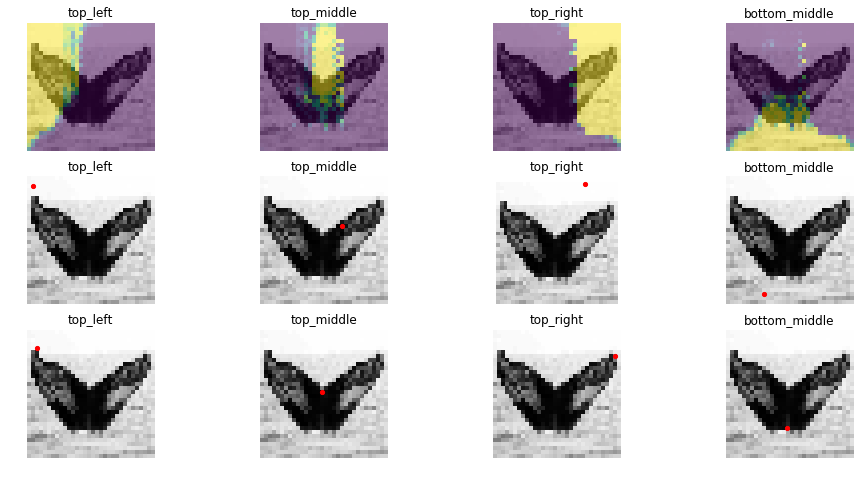

In [126]:
run_test(model)

# UNET

## Generators

### Load Data

In [5]:
from whale_mask_generator import WhaleMaskGenerator

Using TensorFlow backend.


In [6]:
H, W = 32, 32
batch_size = 12

In [130]:
train_generator = WhaleMaskGenerator(IMAGE_DIR, train_data, 4, dim=(H, W), batch_size=batch_size, sigma=1)
val_generator = WhaleMaskGenerator(IMAGE_DIR, val_data, 4, dim=(H, W), batch_size=batch_size, sigma=0)

## Model

In [131]:
def get_unet(H, W, C):
    def conv_block(in_layer, filters, pooling=True):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(in_layer)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        mp = MaxPool2D(pool_size=(2, 2))(x) if pooling else None
        return x, mp
    
    def up_block(in_layer, conv_layer, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(in_layer)
        x = concatenate([x, conv_layer], axis=3)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x
    
    inputs = Input((H, W, C))
    
    c1, mp = conv_block(inputs, 32)
    c2, mp = conv_block(mp, 64)
    c3, mp = conv_block(mp, 128)
    c4, mp = conv_block(mp, 256)
    c5, _ = conv_block(mp, 512, pooling=False)
    
    x = up_block(c5, c4, 256)
    x = up_block(x, c3, 128)
    x = up_block(x, c2, 64)
    x = up_block(x, c1, 32)
    
    out = Conv2D(4, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef, jaccard, 'accuracy'])

    return model

In [132]:
model = get_unet(H, W, 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 32, 32, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
conv2d_79 

In [133]:
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in lrs:
    print(f'Learning Rate: {lr}')
    K.set_value(model.optimizer.lr, lr)
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=1
    )

Learning Rate: 1e-06
Epoch 1/1
100/100 [==============================] - 37s 368ms/step - loss: 0.6930 - dice_coef: 0.0020 - jaccard: 0.0142 - acc: 0.8554
Learning Rate: 1e-05
Epoch 1/1
100/100 [==============================] - 37s 365ms/step - loss: 0.6879 - dice_coef: 0.0020 - jaccard: 3.2390e-07 - acc: 0.9303
Learning Rate: 0.0001
Epoch 1/1
100/100 [==============================] - 36s 359ms/step - loss: 0.0533 - dice_coef: 0.0192 - jaccard: 0.8600 - acc: 0.9359
Learning Rate: 0.001
Epoch 1/1
100/100 [==============================] - 33s 335ms/step - loss: 0.0157 - dice_coef: 0.0205 - jaccard: 1.0000 - acc: 0.9363
Learning Rate: 0.01
Epoch 1/1
100/100 [==============================] - 34s 337ms/step - loss: 0.0157 - dice_coef: 0.0205 - jaccard: 1.0000 - acc: 0.9364


In [135]:
model = get_unet(H, W, 1)
tensorboard = TensorBoardLogger(log_name='UNET-64')

In [136]:
# model.load_weights('checkpoints/unet-64.h5')

In [137]:
K.set_value(model.optimizer.lr, 1e-4)

In [146]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
    validation_data=val_generator,
    validation_steps=50,
    workers=6,
    epochs=10,
)

In [147]:
model.fit_generator(**fit_args)

Epoch 1/10
200/200 [==============================] - 39s 195ms/step - loss: 0.0106 - dice_coef: 0.0246 - jaccard: 1.0000 - acc: 0.9363 - val_loss: 0.0105 - val_dice_coef: 0.0261 - val_jaccard: 2.5000e-06 - val_acc: 0.9990
Epoch 2/10
200/200 [==============================] - 37s 186ms/step - loss: 0.0106 - dice_coef: 0.0246 - jaccard: 1.0000 - acc: 0.9363 - val_loss: 0.0105 - val_dice_coef: 0.0273 - val_jaccard: 2.5000e-06 - val_acc: 0.9990
Epoch 3/10
200/200 [==============================] - 37s 186ms/step - loss: 0.0105 - dice_coef: 0.0247 - jaccard: 1.0000 - acc: 0.9363 - val_loss: 0.0105 - val_dice_coef: 0.0286 - val_jaccard: 2.5000e-06 - val_acc: 0.9990
Epoch 4/10
200/200 [==============================] - 38s 191ms/step - loss: 0.0106 - dice_coef: 0.0246 - jaccard: 1.0000 - acc: 0.9362 - val_loss: 0.0105 - val_dice_coef: 0.0268 - val_jaccard: 2.5000e-06 - val_acc: 0.9990
Epoch 5/10
200/200 [==============================] - 38s 190ms/step - loss: 0.0105 - dice_coef: 0.0247 - ja

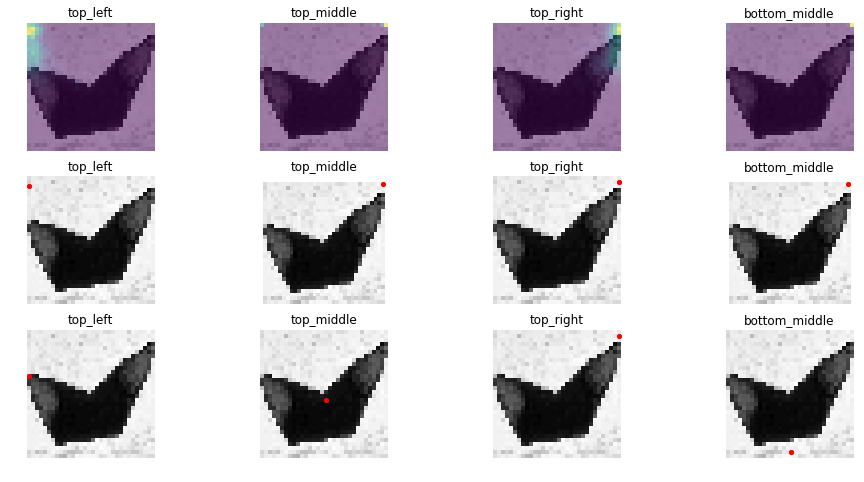

In [148]:
run_test(model)

In [ ]:
model.save_weights('checkpoints/unet-64.h5')

In [ ]:
run_test(H, W, model)